In [45]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import xgboost as xgb
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from sklearn.impute import KNNImputer
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import silhouette_score, pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold

In [37]:
train_df = pd.read_csv('../data/raw/train_data.csv')
train_df.replace('-1', np.nan, inplace=True)
train_df.replace(np.float64(-1.0), np.nan, inplace=True)
train_df['launch_date'] = pd.to_datetime(train_df['launch_date'], errors='coerce')
train_df['date'] = pd.to_datetime(train_df['date'], errors='coerce')
train_df['ind_launch_date'] = pd.to_datetime(train_df['ind_launch_date'], errors='coerce')
submission_df = pd.read_csv('../data/raw/submission_data.csv')
submission_df.replace('-1', np.nan, inplace=True)
submission_df.replace(np.float64(-1.0), np.nan, inplace=True)
template_df = pd.read_csv('../data/processed/submission_template.csv')

In [38]:
all_ids = train_df.cluster_nl.unique()
rows_to_drop = []

for id in all_ids:
    sub_df = train_df[train_df.cluster_nl == id]  
    first_date = sub_df['date'].min()  
    cutoff_date = first_date + pd.DateOffset(months=12)  

    filtered_df = sub_df[sub_df['date'] <= cutoff_date]
    rows_to_drop.append(train_df[train_df.cluster_nl == id].index.difference(filtered_df.index))


rows_to_drop = np.concatenate(rows_to_drop)
train_df = train_df.drop(rows_to_drop)

In [40]:
def preprocess_data(train_df, aggregation_features):

    knn_imputer = KNNImputer(n_neighbors=5)
    knn_imputer.fit(train_df[aggregation_features])   
    complete_data_imputed = knn_imputer.transform(train_df[aggregation_features])
    scaler = StandardScaler()
    complete_data_scaled = scaler.fit_transform(complete_data_imputed)
    print('preprocess_data done')
    return knn_imputer, scaler, complete_data_scaled

def evaluate_kmeans(X, max_clusters=4):
    silhouette_scores = []
    
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(X)
        silhouette_scores.append(silhouette_score(X, kmeans.labels_)) 
    
    optimal_clusters_silhouette = np.argmax(silhouette_scores) + 2
    return optimal_clusters_silhouette

def create_clusters(X, optimal_clusters_silhouette):
    kmeans = KMeans(n_clusters=optimal_clusters_silhouette, random_state=42)
    clusters = kmeans.fit_predict(X)
    print('create_clusters finished')
    return kmeans, clusters

def preprocess_submission_data(submission_df, knn_imputer, aggregation_features):
    # Impute missing data using KNN (using the already fitted imputer)
    submission_imputed = knn_imputer.transform(submission_df[aggregation_features])
    
    # Convert imputed data back to DataFrame with proper column names
    submission_imputed_df = pd.DataFrame(submission_imputed, columns=aggregation_features)
    
    return submission_imputed_df

def assign_clusters_to_submission(submission_df, submission_imputed_df, kmeans, scaler):

    submission_scaled = scaler.transform(submission_imputed_df)
    distances_submission = pairwise_distances(submission_scaled, kmeans.cluster_centers_)
    submission_df.loc[:, 'cluster'] = np.argmin(distances_submission, axis=1)
    print('assign_clusters_to_submission finished')
    return submission_df

def process_data(train_df, submission_df, aggregation_features):

    knn_imputer, scaler, complete_data_scaled = preprocess_data(train_df, aggregation_features)
    optimal_clusters_silhouette = evaluate_kmeans(complete_data_scaled)
    kmeans, complete_data_clusters = create_clusters(complete_data_scaled, optimal_clusters_silhouette)
    train_df['cluster'] = complete_data_clusters
    
    submission_imputed_df = preprocess_submission_data(submission_df, knn_imputer, aggregation_features)
    submission_with_clusters = assign_clusters_to_submission(submission_df, submission_imputed_df, kmeans, scaler)
    print('process data finished')
    return train_df, submission_with_clusters

aggregation_features = train_df.select_dtypes(include=['number']).columns.tolist()

train_df_with_clusters, submission_df_with_clusters = process_data(train_df, submission_df, aggregation_features)

# Display the final clustered dataframes
print(train_df_with_clusters.head())
print(submission_df_with_clusters.head())

preprocess_data done
create_clusters finished
assign_clusters_to_submission finished
process data finished
        brand  che_pc_usd  che_perc_gdp               cluster_nl corporation  \
0  BRAND_354E    1.209114      1.665879  BRAND_354E_COUNTRY_88A3   CORP_D524   
1  BRAND_626D         NaN           NaN  BRAND_626D_COUNTRY_8B47   CORP_01C7   
2  BRAND_45D9    1.209114      1.665879  BRAND_45D9_COUNTRY_88A3   CORP_39F7   
3  BRAND_D724    1.851280      2.051770  BRAND_D724_COUNTRY_445D   CORP_711A   
4  BRAND_4887    1.791199      2.059130  BRAND_4887_COUNTRY_D8B0   CORP_443D   

        country launch_date       date       drug_id ind_launch_date  \
0  COUNTRY_88A3  2014-06-01 2014-06-01  DRUG_ID_8795             NaT   
1  COUNTRY_8B47  2014-06-01 2014-06-01  DRUG_ID_E66E      2014-09-01   
2  COUNTRY_88A3  2014-06-01 2014-06-01  DRUG_ID_F272             NaT   
3  COUNTRY_445D  2014-06-01 2014-06-01  DRUG_ID_1D4E             NaT   
4  COUNTRY_D8B0  2014-06-01 2014-06-01  DRUG_ID_AA88

c:\anaconda3\envs\novartis\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [44]:
train_df_with_clusters[train_df_with_clusters.cluster == 3].cluster_nl.unique()

array(['BRAND_626D_COUNTRY_7D31', 'BRAND_44D9_COUNTRY_AE54',
       'BRAND_74A3_COUNTRY_AE54', 'BRAND_127B_COUNTRY_AE54',
       'BRAND_6C0F_COUNTRY_AE54', 'BRAND_138F_COUNTRY_7D31',
       'BRAND_9DA9_COUNTRY_7D31', 'BRAND_AEF0_COUNTRY_7D31',
       'BRAND_152E_COUNTRY_AE54', 'BRAND_4134_COUNTRY_AE54',
       'BRAND_BBE0_COUNTRY_7D31', 'BRAND_3739_COUNTRY_AE54',
       'BRAND_E68F_COUNTRY_AE54', 'BRAND_C8FD_COUNTRY_AE54',
       'BRAND_0056_COUNTRY_AE54', 'BRAND_7A2E_COUNTRY_AE54',
       'BRAND_7205_COUNTRY_AE54', 'BRAND_71FA_COUNTRY_AE54',
       'BRAND_7A87_COUNTRY_AE54', 'BRAND_F5E9_COUNTRY_AE54',
       'BRAND_076F_COUNTRY_AE54', 'BRAND_5EBB_COUNTRY_AE54',
       'BRAND_9628_COUNTRY_AE54', 'BRAND_CCAA_COUNTRY_AE54',
       'BRAND_51B0_COUNTRY_AE54', 'BRAND_C114_COUNTRY_AE54',
       'BRAND_F05A_COUNTRY_AE54', 'BRAND_62C7_COUNTRY_AE54',
       'BRAND_A12A_COUNTRY_AE54', 'BRAND_7114_COUNTRY_AE54',
       'BRAND_4AB9_COUNTRY_AE54', 'BRAND_4048_COUNTRY_AE54',
       'BRAND_797D_COUNT

<Axes: >

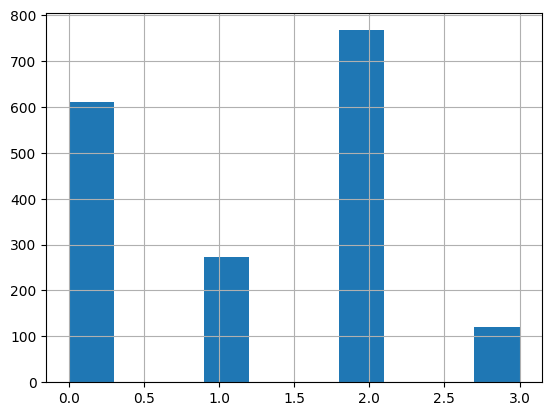

In [43]:
submission_df_with_clusters.cluster.hist()

In [15]:
submission_df_with_clusters.dtypes

brand                  object
che_pc_usd            float64
che_perc_gdp          float64
cluster_nl             object
corporation            object
country                object
launch_date            object
date                   object
drug_id                object
ind_launch_date        object
indication             object
insurance_perc_che    float64
population            float64
prev_perc             float64
price_month           float64
price_unit            float64
public_perc_che       float64
therapeutic_area       object
target                float64
cluster                 int64
dtype: object

In [50]:
def preprocess_data_with_dates(train_df, target_column='target', cluster_column='cluster'):
  

    X = train_df.drop(columns=[target_column, cluster_column])
    y = train_df[target_column]
    date_columns = ['date', 'launch_date', 'ind_launch_date']
    
    for col in date_columns:
        if col in X.columns:

            X[col] = pd.to_datetime(X[col], errors='coerce')
            
            # Extract date features
            X[col + '_year'] = X[col].dt.year.fillna(0).astype(int)  # Fill missing years with 0
            X[col + '_month'] = X[col].dt.month.fillna(0).astype(int)
            X[col + '_day'] = X[col].dt.day.fillna(0).astype(int)
            X[col + '_dayofweek'] = X[col].dt.dayofweek.fillna(0).astype(int)
            X[col + '_dayofyear'] = X[col].dt.dayofyear.fillna(0).astype(int)
            X[col + '_is_month_start'] = X[col].dt.is_month_start.fillna(False).astype(int)
            X[col + '_is_month_end'] = X[col].dt.is_month_end.fillna(False).astype(int)
            X[col + '_is_quarter_start'] = X[col].dt.is_quarter_start.fillna(False).astype(int)
            X[col + '_is_quarter_end'] = X[col].dt.is_quarter_end.fillna(False).astype(int)
            X[col + '_is_year_start'] = X[col].dt.is_year_start.fillna(False).astype(int)
            X[col + '_is_year_end'] = X[col].dt.is_year_end.fillna(False).astype(int)

            X = X.drop(columns=[col])
    
    X = X.fillna(0) 

    numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

    return X, y, numeric_cols, categorical_cols

In [54]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def train_xgboost_model(
    name, 
    train_df, 
    target_column='target', 
    cluster_column='cluster', 
    save_model_path='best_xgboost_model.pkl', 
    save_grid_search_path='xgboost_grid_search.pkl'
):

    save_model_path = f'../data/models/{name}.pkl'
    X, y, numeric_cols, categorical_cols = preprocess_data_with_dates(train_df, target_column, cluster_column)
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_cols),  
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols) 
        ])
    
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

    param_grid = {
        'model__n_estimators': [100, 300, 500],  
        'model__learning_rate': [0.01, 0.05, 0.1, 0.2], 
        'model__max_depth': [3, 5, 10],  
        'model__subsample': [0.8, 1.0], 
        'model__colsample_bytree': [0.8, 1.0],  
        'model__min_child_weight': [1, 3, 5],  
        'model__gamma': [0, 1],   
    }
    
    grid_search = GridSearchCV(
        pipeline, 
        param_grid, 
        cv=3, 
        scoring=mape_scorer, 
        n_jobs=-1, 
        verbose=1
    )
    
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    joblib.dump(best_model, save_model_path)
    
    return best_model

In [55]:
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

name_list = ['zero','one','two','three','four','five','six','seven','eight']
for i in range(4):
    best_model = train_xgboost_model(name_list[i],train_df=train_df[train_df.cluster==i])
    print(f'xgboost for cluster {i} completed.')

Fitting 3 folds for each of 864 candidates, totalling 2592 fits
xgboost for cluster 0 completed.
Fitting 3 folds for each of 864 candidates, totalling 2592 fits
xgboost for cluster 1 completed.
Fitting 3 folds for each of 864 candidates, totalling 2592 fits
xgboost for cluster 2 completed.
Fitting 3 folds for each of 864 candidates, totalling 2592 fits


c:\anaconda3\envs\novartis\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


xgboost for cluster 3 completed.


In [40]:
loaded_model = joblib.load(('../data/models/zero.pkl'))

In [56]:
s_df = submission_df_with_clusters.copy()
submission_array = np.zeros([len(template_df)])
for i,row in template_df.iterrows():
    X = s_df[(s_df.date==row.iloc[0])&(s_df.cluster_nl==row.iloc[1])].head()
    loaded_model = joblib.load(('../data/models/'+name_list[X.cluster.values[0].astype(int)]+'.pkl'))
    X_test,_,_,_ = preprocess_data_with_dates(X, target_column='target', cluster_column='cluster')
    submission_array[i] = loaded_model.predict(X_test).item()
template_df.prediction = submission_array

In [57]:
template_df.to_csv('../data/outputs/try3_RR.csv',index=False)